# Raman Spectroscopy Semester Project
## COSC525
This notebook builds a CNN Spectra Decomposition model based on the work presented in [J. Zhang, P.-L. Xin, X.-Y. Wang, H.-Y. Chen, and D.-W. Li, “Deep
Learning-Based Spectral Extraction for Improving the Performance
of Surface-Enhanced Raman Spectroscopy Analysis on Multiplexed
Identification and Quantitation,” J. Phys. Chem. A, vol. 126, no. 14,
pp. 2278-2285, 2022. DOI: 10.1021/acs.jpca.1c10681]

The data preprocessing stages were customized to fit the needs of our self-collected, experimental data. All Pandas data frame manipulation/creation code was written by our team. 

The model architecture was reused because of it's previous success and similarity to our data input. The original model featured DDM, MVD, and TMTD components. These were changed to our mixture components of Soapstone, Olivine, and Gypsum. Various lines where changed whenever we ran into shape issues. A Savgol filter was introduced to smooth our data.

Plotting functions were written for the following reasons
<ul>
    <li>Visualize training loss and similarity</li>
    <li>Visualize validation loss and similarity</li>
    <li>Visualize Training data and labels</li>
    <li>Visualize Model's predictions relative to ground truth labels</li>
</ul>



In [110]:
import pandas as pd 
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch 
from scipy import signal 
from configparser import ConfigParser
from sklearn import preprocessing 

In [111]:
# Read in CSV file
Spectra_df = pd.read_csv('new_data.csv')
Spectra_df.set_index("Raman_shift", inplace=True)
print(Spectra_df.head(10))

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#print(torch.cuda.get_device_name(torch.cuda.current_device()))

                mixture   mixture.1   mixture.2   mixture.3   mixture.4  \
Raman_shift                                                               
642.237     -747.215690 -766.227272 -661.336137 -796.801343 -697.169154   
643.118     -733.747829 -731.403448 -651.546775 -788.835834 -697.527020   
643.999     -711.626477 -691.792918 -635.407290 -779.778725 -698.359542   
644.879     -681.918941 -651.485532 -606.519433 -771.084509 -696.716688   
645.760     -644.120067 -613.950091 -566.956140 -752.195819 -682.950454   
646.641     -603.937998 -581.671274 -522.017997 -712.366990 -656.915051   
647.521     -566.984106 -555.247587 -480.623137 -656.046918 -617.372868   
648.401     -535.781602 -526.975993 -443.365440 -593.158396 -564.213415   
649.281     -511.612163 -499.043223 -414.595077 -536.001373 -511.947044   
650.161     -486.674340 -475.758818 -394.891604 -487.633916 -468.328862   

              mixture.5   mixture.6   mixture.7   mixture.8   mixture.9  ...  \
Raman_shift        

In [112]:
def snv(X):
    """Apply SNV normalization to a Pandas Series (column)."""
    mean = X.mean()
    std_dev = X.std()
    return (X- mean) / std_dev

def min_max(X): 

    """" Apply  the min-max scaling  for the normalization"""

    min = np.min(X , axis = 0)
    max = np.max(X, axis = 0)
    x_normalized = (X -min)/ (max - min )
    return x_normalized

def perform_tsne(X, n_components=3, perplexity =30):
    """
    Apply t-SNE to the dataset and plot the result.

    Parameters:
    - X: The high-dimensional data.
    - n_components: The dimension of the embedded space (default 2).
    - perplexity: The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50.

    Returns:
    - X_tsne: The dataset transformed into the embedded space.
    """

    # Apply t-SNE to the data
    tsne = TSNE(n_components=n_components, perplexity= perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X)

    return X_tsne

def perform_pca(X, n_components = 2): 


    # Apply PCA to the data
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)


    return X_pca


In [113]:
Spectra_df.tail(30)

mixture   mixture.1  mixture.2   mixture.3   mixture.4  \
Raman_shift                                                             
1681.224    -35.251092   33.817771  55.469445   43.907416  113.641179   
1681.936    -23.447740   34.298692  71.637182   21.694613  100.075698   
1682.648    -13.237681   53.388589  74.023557   -6.445607   91.317017   
1683.360     -3.130707   84.183400  64.946246  -24.597889   93.348800   
1684.071      8.907084  112.589296  49.518411  -23.924287  107.910502   
1684.783     23.380872  134.631744  32.564961   -1.928390  134.656540   
1685.494     37.948815  148.234582  11.406860   33.339730  165.339528   
1686.206     53.932564  151.467802 -15.377812   66.412902  189.884812   
1686.917     71.623647  137.167819 -44.982111   87.673026  193.318659   
1687.628     84.319619  105.476699 -70.516730   85.527381  176.853794   
1688.339     84.825354   59.608490 -89.065121   53.475917  146.780943   
1689.049     70.854573   10.235531 -93.241734    2.199162  110.455726   
1689.760     53.141338  -30.516006 -79.299225  -44.708301   79.816322   
1690.471     39.325779  -58.644967 -57.453940  -75.642839   56.464099   
1691.181     29.227327  -75.884825 -33.717069  -95.065019   33.710274   
1691.892     15.923404  -80.194110 -12.920685 -110.771310    4.858510   
1692.602     -0.957418  -80.291035   0.861876 -125.591244  -34.242160   
1693.312     -7.581718  -79.634405   1.892856 -142.670247  -80.989266   
1694.022     -1.478429  -76.764943  -8.752217 -153.846686 -113.256199   
1694.732      3.331353  -66.984106 -27.569086 -144.065886 -129.039002   
1695.441     -2.781616  -50.593363 -53.825369 -112.289200 -134.276996   
1696.151    -14.005845  -34.528887 -77.602450  -69.700874 -130.397471   
1696.861    -25.843914  -26.376597 -89.565269  -27.014654 -116.687461   
1697.570    -43.811559  -20.820743 -89.205962    8.129095  -95.271280   
1698.279    -64.555921  -16.596772 -71.778120   38.011406  -71.979454   
1698.988    -80.367189  -12.214249 -44.697062   59.959901  -49.652872   
1699.698    -83.851295  -11.363105 -18.593453   71.187094  -27.890619   
1700.406    -61.099167  -23.227717   9.350473   68.925403  -10.199474   
1701.115    -12.322259  -49.424353  42.163626   59.398260    2.784870   
1701.824     48.250173  -86.052775  81.106798   47.065675    8.330194   

              mixture.5   mixture.6   mixture.7   mixture.8  mixture.9  ...  \
Raman_shift                                                             ...   
1681.224     185.143537   15.649539   47.938903  -15.707031  56.948150  ...   
1681.936     177.248454   28.002229   54.039591  -30.201286  72.020925  ...   
1682.648     162.598284   49.888597   61.550499  -26.235191  86.669548  ...   
1683.360     149.046440   79.946408   68.367646  -10.104515  95.327413  ...   
1684.071     137.570187  106.175314   72.468229    7.257103  95.180215  ...   
1684.783     132.039763  120.698287   72.833606   17.772046  89.198547  ...   
1685.494     127.034176  121.064816   72.808762   19.901387  82.961141  ...   
1686.206     115.810162  121.689692   75.599160   22.370232  75.220198  ...   
1686.917      99.745299  124.199903   81.387684   28.162622  72.379857  ...   
1687.628      85.592441  130.218877   81.011372   35.249761  71.400163  ...   
1688.339      70.076554  137.806702   70.438757   37.702316  62.556307  ...   
1689.049      49.896299  133.975142   55.705929   33.488223  51.355114  ...   
1689.760      29.394075  121.224426   38.012862   16.752445  43.494996  ...   
1690.471       6.109583   99.051203   24.678154   -2.969736  33.044012  ...   
1691.181     -20.750253   68.202629   13.092165  -23.663161  21.751080  ...   
1691.892     -49.752000   36.751757   -4.097434  -43.543754   8.236933  ...   
1692.602     -69.747443    9.706823  -32.387235  -55.670782  -5.922670  ...   
1693.312     -76.478022  -13.549203  -70.039216  -57.999626 -24.802511  ...   
1694.022     -68.479412  -28.539270 -102.846623  -48.472132 -40.351100  ...   
1694.732     -49.54

In [114]:
print(Spectra_df.columns)

Index(['mixture', 'mixture.1', 'mixture.2', 'mixture.3', 'mixture.4',
       'mixture.5', 'mixture.6', 'mixture.7', 'mixture.8', 'mixture.9',
       ...
       'olivine.990', 'olivine.991', 'olivine.992', 'olivine.993',
       'olivine.994', 'olivine.995', 'olivine.996', 'olivine.997',
       'olivine.998', 'olivine.999'],
      dtype='object', length=4000)


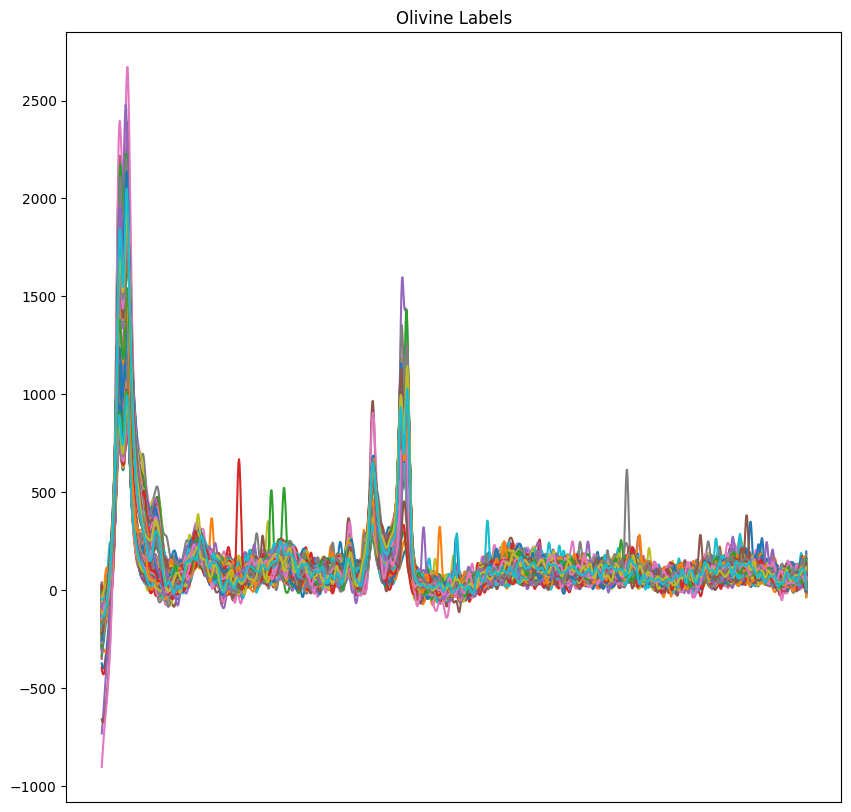

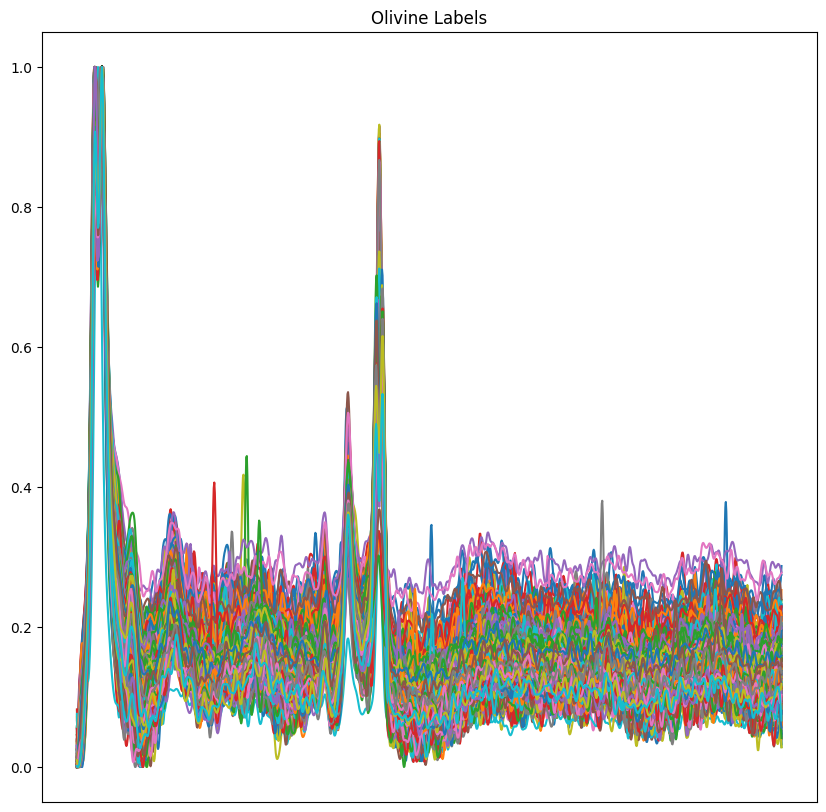

In [115]:
from scipy.signal import savgol_filter
def smooth(x, window_length=11, polyorder=3):
    """Smooth the data using a Savitzky-Golay filter."""
    return savgol_filter(x, window_length, polyorder)

for column_name in Spectra_df.columns:
    Spectra_df[column_name] = Spectra_df[column_name].astype(float)
    smoothed = smooth(Spectra_df[column_name])
    Spectra_df[column_name] = smoothed

plt.figure(figsize=(10, 10))
plt.plot(Spectra_df.filter(regex=r'^olivine(\.\d+)?$'))
plt.title("Olivine Labels")
plt.xticks([])
plt.show()

for column_name in Spectra_df.columns:
    min_max_col = min_max(Spectra_df[column_name])
    Spectra_df[column_name] = min_max_col
    
plt.figure(figsize=(10, 10))
plt.plot(Spectra_df.filter(regex=r'^olivine(\.\d+)?$'))
plt.title("Olivine Labels")
plt.xticks([])
plt.show()




In [117]:
Spectra_df.shape

(1339, 4000)

In [118]:
mixture_count = 0
gypsum_count = 0
soapstone_count = 0
olivine_count = 0
nonlabel_count = 0
for column in Spectra_df.columns:
    if column[0:7] == "mixture": mixture_count+=1
    elif column[0:6] == "gypsum": gypsum_count+=1
    elif column[0:7] == "olivine": olivine_count+=1
    elif  column[0:9] == "soapstone": soapstone_count+=1
    else: nonlabel_count+=1
print(f"Mixture count: {mixture_count}")
print(f"Gypsum count: {gypsum_count}")
print(f"Soapstone count: {soapstone_count}")
print(f"Olivine count: {olivine_count}")
print(f"Nonlabel count: {nonlabel_count}")


Mixture count: 1000
Gypsum count: 1000
Soapstone count: 1000
Olivine count: 1000
Nonlabel count: 0


In [119]:
Spectra_df.columns

Index(['mixture', 'mixture.1', 'mixture.2', 'mixture.3', 'mixture.4',
       'mixture.5', 'mixture.6', 'mixture.7', 'mixture.8', 'mixture.9',
       ...
       'olivine.990', 'olivine.991', 'olivine.992', 'olivine.993',
       'olivine.994', 'olivine.995', 'olivine.996', 'olivine.997',
       'olivine.998', 'olivine.999'],
      dtype='object', length=4000)

In [121]:
selected = Spectra_df.filter(regex=r'^mixture(\.\d+)?$')
selected

mixture  mixture.1  mixture.2  mixture.3  mixture.4  mixture.5  \
Raman_shift                                                                    
642.237      0.000000   0.000000   0.000000   0.001823   0.002974   0.007807   
643.118      0.002139   0.006356   0.000917   0.000000   0.000384   0.003235   
643.999      0.005205   0.012429   0.004097   0.000830   0.000000   0.000661   
644.879      0.008976   0.018206   0.008978   0.003917   0.001558   0.000000   
645.760      0.013230   0.023670   0.014997   0.008868   0.004793   0.001166   
...               ...        ...        ...        ...        ...        ...   
1698.988     0.084296   0.118477   0.096942   0.133368   0.103162   0.108984   
1699.698     0.084440   0.117703   0.101287   0.135421   0.106659   0.108101   
1700.406     0.086771   0.115677   0.106330   0.135890   0.109574   0.107413   
1701.115     0.091917   0.112163   0.111798   0.134532   0.111535   0.107213   
1701.824     0.100506   0.106928   0.117415   0.131105   0.112172   0.107796   

             mixture.6  mixture.7  mixture.8  mixture.9  ...  mixture.990  \
Raman_shift                                              ...                
642.237       0.000000   0.000000   0.000322   0.000000  ...     0.003761   
643.118       0.008141   0.002337   0.000000   0.000342  ...     0.003432   
643.999       0.016134   0.004698   0.001039   0.003034  ...     0.003283   
644.879       0.023836   0.007141   0.003239   0.007531  ...     0.003278   
645.760       0.031103   0.009721   0.006402   0.013289  ...     0.003385   
...                ...        ...        ...        ...  ...          ...   
1698.988      0.105884   0.097160   0.101047   0.103920  ...     0.010650   
1699.698      0.107202   0.103204   0.105336   0.107316  ...     0.010801   
1700.406      0.109682   0.109411   0.110013   0.111610  ...     0.011199   
1701.115      0.113630   0.115348   0.115049   0.116797  ...     0.011879   
1701.824      0.119356   0.120582   0.120413   0.122872  ...     0.012876   

             mixture.991  mixture.992  mixture.993  mixture.994  mixture.995  \
Raman_shift                                                                    
642.237         0.005078     0.002071     0.004115     0.006512     0.004915   
643.118         0.003338     0.000819     0.003574     0.006235     0.003968   
643.999         0.002269     0.000155     0.003088     0.005754     0.003262   
644.879         0.001750     0.000000     0.002685     0.005146     0.002768   
645.760         0.001662     0.000274     0.002392     0.004488     0.002454   
...                  ...          ...          ...          ...          ...   
1698.988        0.011148     0.012498     0.013247     0.013818     0.013229   
1699.698        0.010657     0.012670     0.012783     0.013346     0.013423   
1700.406        0.010161     0.012880     0.012316     0.012564     0.013675   
1701.115        0.009694     0.013142     0.011894     0.011399     0.014038   
1701.824        0.009293     0.013469     0.011565     0.009778     0.014563   

             mixture.996  mixture.997  mixture.998  mixture.999  
Raman_shift                                                      
642.237         0.002302     0.000000     0.007258     0.005641  
643.118         0.002250     0.001090     0.004800     0.004004  
643.999         0.002361     0.002023     0.002853     0.003049  
644.879         0.002600     0.002807     0.001409     0.002653  
645.760         0.002931     0.003450     0.000461     0.002695  
...                  ...          ...          ...          ...  
1698.988        0.011934     0.011489     0.012907     0.015221  
1699.698        0.012315     0.011006     0.012551     0.014959  
1700.406        0.013083     0.010714     0.012303     0.014585  
1701.115        0.014245     0.010681     0.012196     0.014113  
1701.824        0.015811     0.010981     0.012265     0.013560  

[1339 rows x 1000 columns]

## Plot the Mixture Training Data and the Component Labels

1000


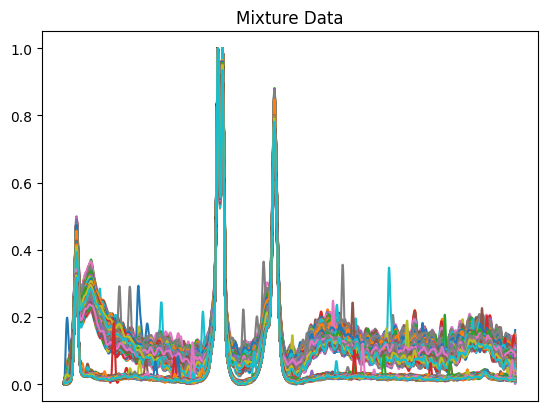

In [122]:
plt.plot(Spectra_df.filter(regex=r'^mixture(\.\d+)?$'))
plt.title("Mixture Data")
plt.xticks([])
print(len(Spectra_df.filter(regex=r'^mixture(\.\d+)?$').columns))

4000


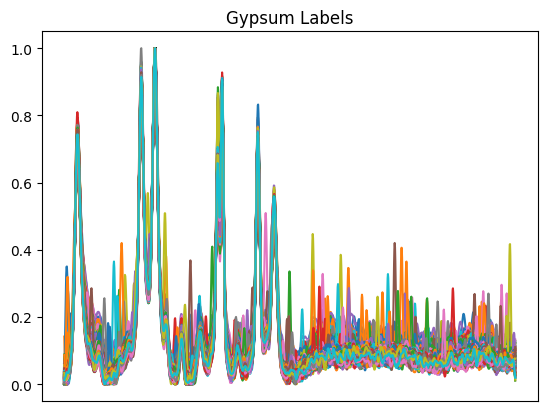

In [123]:
plt.plot(Spectra_df.filter(regex=r'^gypsum(\.\d+)?$'))
plt.title("Gypsum Labels")
plt.xticks([])
print(len(Spectra_df.columns))

4000


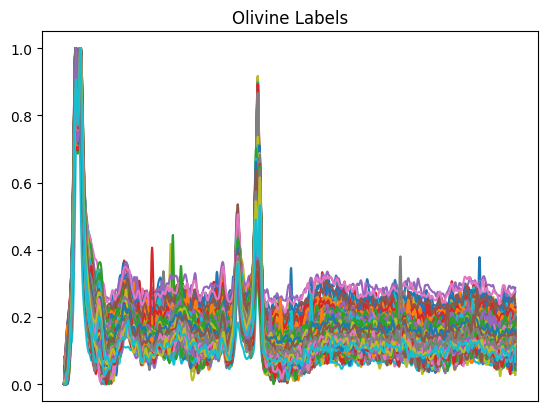

In [124]:
plt.plot(Spectra_df.filter(regex=r'^olivine(\.\d+)?$'))
plt.title("Olivine Labels")
plt.xticks([])
print(len(Spectra_df.columns))

4000


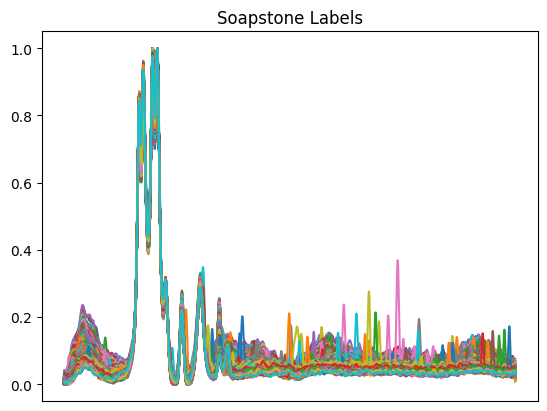

In [125]:
plt.plot(Spectra_df.filter(regex=r'^soapstone(\.\d+)?$'))
plt.title("Soapstone Labels")
plt.xticks([])
print(len(Spectra_df.columns))


In [126]:
from sklearn.model_selection import train_test_split
mixture_data = Spectra_df.filter(regex=r'^mixture(\.\d+)?$').to_numpy()
print(f"Mixture shape: {mixture_data.shape}")
# Columns = Samples
# Rows = Intensity at raman_shift
# Read Test Data csv
Test_df = pd.read_csv('COSC525_Data1.csv')
Test_df.columns = Test_df.iloc[0]
Test_df = Test_df.drop(0)
Test_df.set_index("Raman_shifts", inplace=True)
#print(Test_df.head(10))

soapstone_data = Spectra_df.filter(regex=r'^soapstone(\.\d+)?$').to_numpy()
olivine_data = Spectra_df.filter(regex=r'^olivine(\.\d+)?$').to_numpy()
gypsum_data = Spectra_df.filter(regex=r'^gypsum(\.\d+)?$').to_numpy()
test_data = Test_df["nonLabel"].to_numpy()
print(f"Soapstone shape: {soapstone_data.shape}")

mixture_train, mixture_val, soapstone_train, soapstone_val, olivine_train, olivine_val,\
    gypsum_train, gypsum_val = train_test_split(mixture_data.T, soapstone_data.T, olivine_data.T, \
                                                gypsum_data.T, test_size=0.1, random_state=42)
print(f"Mixture train shape: {mixture_train.shape}")

train_data = np.zeros((4, mixture_train.shape[1], mixture_train.shape[0]))
train_data[0] = mixture_train.T
train_data[1] = soapstone_train.T
train_data[2] = olivine_train.T
train_data[3] = gypsum_train.T

val_data = np.zeros((4, mixture_train.shape[1], mixture_val.shape[0]))
val_data[0] = mixture_val.T
val_data[1] = soapstone_val.T
val_data[2] = olivine_val.T
val_data[3] = gypsum_val.T

# Print all of the val data and train data shapes
for i in range(4):
    print(f"Train data shape: {train_data[i].shape}")
    print(f"Val data shape: {val_data[i].shape}")


Mixture shape: (1339, 1000)
Soapstone shape: (1339, 1000)
Mixture train shape: (900, 1339)
Train data shape: (1339, 900)
Val data shape: (1339, 100)
Train data shape: (1339, 900)
Val data shape: (1339, 100)
Train data shape: (1339, 900)
Val data shape: (1339, 100)
Train data shape: (1339, 900)
Val data shape: (1339, 100)


## Model BluePrint

In [127]:
import torch
import torch.nn as nn
from torch.nn import Module, Sequential
from torch.nn import functional as func


__all__ = ['PreprocessUnit', 'ExtractorUnit', 'SENN']

class PreprocessUnit(Module):
    def __init__(self):
        super(PreprocessUnit, self).__init__()
        self.preprocess = Sequential(
                                    nn.Conv1d(1, 6, 3, padding=1),
                                    nn.BatchNorm1d(6),
                                    nn.ReLU(),
                                    nn.Conv1d(6, 12, 3, padding=1),
                                    nn.BatchNorm1d(12),
                                    nn.ReLU()
                                )

    def forward(self, spectra):
        return self.preprocess(spectra)


class ExtractorUnit(Module):
    def __init__(self, linearSize):
        super(ExtractorUnit, self).__init__()
        self.extractor = Sequential(
                                    nn.Conv1d(12, 6, 3, padding=1),
                                    nn.BatchNorm1d(6),
                                    nn.ReLU(),
                                    nn.Conv1d(6, 1, 3, padding=1),
                                    nn.BatchNorm1d(1),
                                    nn.ReLU(),
                                    nn.Linear(linearSize, linearSize, bias=True),
                                    nn.Sigmoid()
                                )

    def forward(self, spectra):
        return self.extractor(spectra)


class  SENN(Module):
    def __init__(self, preprocessUnit: Module, *extractors):
        super(SENN, self).__init__()
        self.preprocessUnit = preprocessUnit
        self.extractors = extractors
    
        # Check for CUDA availability and move the model to GPU if available
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)



    def forward(self, spectrum):
        latentVar = self.preprocessUnit(spectrum.to(self.device))
        components = []
        for extractor in self.extractors:
            components.append(extractor(latentVar))
        return components

In [128]:
def fit_SENN(model, train_data, val_data, criterion, optimizers, comment, epochs=3):
    PRINT_TEMPLATE = '\tEpoch {}/{}: training loss: {:.4f}/{:.4f}/{:.4f} (SOAP/OLIV/GYP); ' + \
                        'train similarity: {:.4f}/{:.4f}/{:.4f} (SOAP/OLIV/GYP); ' + \
                        'validation loss: {:.4f}/{:.4f}/{:.4f} (SOAP/OLIV/GYP); ' + \
                        'validation similarity: {:.4f}/{:.4f}/{:.4f} (SOAP/OLIV/GYP)'
    train_soapstone_loss_record = np.zeros(epochs, dtype=np.float64)
    train_soapstone_similarity_record = np.zeros(epochs, dtype=np.float64)
    train_olivine_loss_record = np.zeros(epochs, dtype=np.float64)
    train_olivine_similarity_record = np.zeros(epochs, dtype=np.float64)
    train_gypsum_loss_record = np.zeros(epochs, dtype=np.float64)
    train_gypsum_similarity_record = np.zeros(epochs, dtype=np.float64)
    val_soapstone_loss_record = np.zeros(epochs, dtype=np.float64)
    val_soapstone_similarity_record = np.zeros(epochs, dtype=np.float64)
    val_olivine_loss_record = np.zeros(epochs, dtype=np.float64)
    val_olivine_similarity_record = np.zeros(epochs, dtype=np.float64)
    val_gypsum_loss_record = np.zeros(epochs, dtype=np.float64)
    val_gypsum_similarity_record = np.zeros(epochs, dtype=np.float64)
    
    for epoch in range(epochs):
        soapstone_train_loss = 0
        olivine_train_loss = 0
        gypsum_train_loss = 0
        soapstone_train_similarity = torch.tensor(0.0, device=device)
        olivine_train_similarity = torch.tensor(0.0, device=device)
        gypsum_train_similarity = torch.tensor(0.0, device=device)
        train_set_length = 0
        
        for i_m in range(len(model)):
            model[i_m] = model[i_m].to(device)
        
        for i_m in range(len(model)):
            model[i_m].train()
        ## Loop through training samples
        for i in range(train_data.shape[2]): 
            mixture = torch.from_numpy(train_data[0, :, i]).float().unsqueeze(0).unsqueeze(0).to(device)
            soapstone = torch.from_numpy(train_data[1, :, i]).float().to(device)
            olivine = torch.from_numpy(train_data[2, :, i]).float().to(device)
            gypsum = torch.from_numpy(train_data[3, :, i]).float().to(device)
            
            for i_o in range(len(optimizers)):
                optimizers[i_o].zero_grad()
            
            predict_soapstone = model[1](model[0](mixture))
            predict_olivine = model[2](model[0](mixture))
            predict_gypsum = model[3](model[0](mixture))
            soapstone_loss = criterion[0](predict_soapstone.squeeze(1), soapstone.unsqueeze(0))
            olivine_loss = criterion[1](predict_olivine.squeeze(1), olivine.unsqueeze(0))
            gypsum_loss = criterion[2](predict_gypsum.squeeze(1), gypsum.unsqueeze(0))
            soapstone_train_loss += soapstone_loss
            olivine_train_loss += olivine_loss
            gypsum_train_loss += gypsum_loss
            soapstone_similarity = comment(predict_soapstone.squeeze(1), soapstone)
            olivine_similarity = comment(predict_olivine.squeeze(1), olivine)
            gypsum_similarity = comment(predict_gypsum.squeeze(1), gypsum)
            soapstone_train_similarity += torch.abs(torch.sum(soapstone_similarity.detach()))
            olivine_train_similarity += torch.abs(torch.sum(olivine_similarity.detach()))
            gypsum_train_similarity += torch.abs(torch.sum(gypsum_similarity.detach()))

            soapstone_loss.backward()
            olivine_loss.backward()
            gypsum_loss.backward()
            train_set_length += 1
            for i_opt in range(3):
                optimizers[i_opt].step()
        # Evaluate the Validation Set for Model at the end of each epoch
        for i_m in range(len(model)):
            model[i_m].eval()
        val_soapstone_loss = 0
        val_olivine_loss = 0
        val_gypsum_loss = 0
        val_soapstone_similarity =  torch.tensor(0.0, device=device)
        val_olivine_similarity =  torch.tensor(0.0, device=device)
        val_gypsum_similarity =  torch.tensor(0.0, device=device)
        val_set_length = 0
        with torch.no_grad():
            for i in range(val_data.shape[2]):
                mixture_val = torch.from_numpy(val_data[0, :, i]).float().unsqueeze(0).unsqueeze(0).to(device)
                soapstone_val = torch.from_numpy(val_data[1, :, i]).float().to(device)
                olivine_val = torch.from_numpy(val_data[2, :, i]).float().to(device)
                gypsum_val = torch.from_numpy(val_data[3, :, i]).float().to(device)
                predict_soapstone_val = model[1](model[0](mixture_val))
                predict_olivine_val = model[2](model[0](mixture_val))
                predict_gypsum_val = model[3](model[0](mixture_val))
                soapstone_loss_val = criterion[0](predict_soapstone_val.squeeze(1), soapstone_val.unsqueeze(0))
                olivine_loss_val = criterion[1](predict_olivine_val.squeeze(1), olivine_val.unsqueeze(0))
                gypsum_loss_val = criterion[2](predict_gypsum_val.squeeze(1), gypsum_val.unsqueeze(0))
                val_soapstone_loss += soapstone_loss_val
                val_olivine_loss += olivine_loss_val
                val_gypsum_loss += gypsum_loss_val
                soapstone_similarity_val = comment(predict_soapstone_val.squeeze(1), soapstone_val)
                olivine_similarity_val = comment(predict_olivine_val.squeeze(1), olivine_val)
                gypsum_similarity_val = comment(predict_gypsum_val.squeeze(1), gypsum_val)
                val_soapstone_similarity += torch.abs(torch.sum(soapstone_similarity_val.detach()))
                val_olivine_similarity += torch.abs(torch.sum(olivine_similarity_val.detach()))
                val_gypsum_similarity += torch.abs(torch.sum(gypsum_similarity_val.detach()))

                val_set_length += 1

        train_soapstone_loss_record[epoch] = soapstone_train_loss
        train_olivine_loss_record[epoch] = olivine_train_loss
        train_gypsum_loss_record[epoch] = gypsum_train_loss
        train_soapstone_similarity_record[epoch] = soapstone_train_similarity / train_set_length
        train_olivine_similarity_record[epoch] = olivine_train_similarity / train_set_length
        train_gypsum_similarity_record[epoch] = gypsum_train_similarity / train_set_length
        val_soapstone_loss_record[epoch] = val_soapstone_loss
        val_olivine_loss_record[epoch] = val_olivine_loss
        val_gypsum_loss_record[epoch] = val_gypsum_loss
        val_soapstone_similarity_record[epoch] = val_soapstone_similarity / val_set_length
        val_olivine_similarity_record[epoch] = val_olivine_similarity / val_set_length
        val_gypsum_similarity_record[epoch] = val_gypsum_similarity / val_set_length

        print(PRINT_TEMPLATE.format(epoch + 1, epochs, train_soapstone_loss_record[epoch], train_olivine_loss_record[epoch], train_gypsum_loss_record[epoch],
                                    train_soapstone_similarity_record[epoch], train_olivine_similarity_record[epoch], train_gypsum_similarity_record[epoch], 
                                    val_soapstone_loss_record[epoch], val_olivine_loss_record[epoch], val_gypsum_loss_record[epoch], val_soapstone_similarity_record[epoch],
                                    val_olivine_similarity_record[epoch], val_gypsum_similarity_record[epoch]))
    return {'model': model,
            'soapstone_loss': train_soapstone_loss_record,
            'olivine_loss': train_olivine_loss_record,
            'gypsum_loss': train_gypsum_loss_record,
            'soapstone_simi': train_soapstone_similarity_record,
            'olivine_simi': train_olivine_similarity_record,
            'gypsum_simi': train_gypsum_similarity_record,
            'val_soapstone_loss': val_soapstone_loss_record,
            'val_olivine_loss': val_olivine_loss_record,
            'val_gypsum_loss': val_gypsum_loss_record,
            'val_soapstone_simi': val_soapstone_similarity_record,
            'val_olivine_simi': val_olivine_similarity_record,
            'val_gypsum_simi': val_gypsum_similarity_record}


In [129]:
import torch.nn as nn
import torch.optim as opt

modules = [
    PreprocessUnit().to(device),
    ExtractorUnit(train_data.shape[1]).to(device),
    ExtractorUnit(train_data.shape[1]).to(device),
    ExtractorUnit(train_data.shape[1]).to(device),
]
# losses
criterions = [
    nn.MSELoss(),
    nn.MSELoss(),
    nn.MSELoss()
]
# config optimizer and learning rate
optimizers = [
    opt.Adam([{'params': modules[1].parameters()}, {'params':modules[0].parameters()}], 0.0001),
    opt.Adam(modules[2].parameters(), 0.0001),
    opt.Adam(modules[3].parameters(), 0.0001)
]
# evaluate result
comment = nn.CosineSimilarity()

In [130]:
print(f"{'Start training model!':=^100s}")
tape = fit_SENN(modules, train_data,val_data, criterions, optimizers, comment, epochs=50)

=======================================Start training model!========================================
	Epoch 1/50: training loss: 6.2079/5.9251/5.0436 (SOAP/OLIV/GYP); train similarity: 0.9687/0.9758/0.9788 (SOAP/OLIV/GYP); validation loss: 0.6302/0.3141/0.3384 (SOAP/OLIV/GYP); validation similarity: 0.9326/0.9699/0.9650 (SOAP/OLIV/GYP)
	Epoch 2/50: training loss: 0.1126/1.1206/0.2879 (SOAP/OLIV/GYP); train similarity: 0.9982/0.9906/0.9969 (SOAP/OLIV/GYP); validation loss: 0.6999/0.2775/0.3144 (SOAP/OLIV/GYP); validation similarity: 0.9299/0.9740/0.9667 (SOAP/OLIV/GYP)
	Epoch 3/50: training loss: 0.1010/1.1067/0.2670 (SOAP/OLIV/GYP); train similarity: 0.9984/0.9907/0.9971 (SOAP/OLIV/GYP); validation loss: 0.7418/0.2539/0.2984 (SOAP/OLIV/GYP); validation similarity: 0.9296/0.9764/0.9682 (SOAP/OLIV/GYP)
	Epoch 4/50: training loss: 0.0948/1.0997/0.2541 (SOAP/OLIV/GYP); train similarity: 0.9985/0.9907/0.9973 (SOAP/OLIV/GYP); validation loss: 0.7225/0.2452/0.2809 (SOAP/OLIV/GYP); validation 

In [131]:
def plot_training_loss(tape):
    plt.plot(tape['soapstone_loss'], label='Soapstone', color='red')
    plt.plot(tape['olivine_loss'], label='Olivine', color='green')
    plt.plot(tape['gypsum_loss'], label='Gypsum', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss')
    plt.show()

In [132]:
def plot_training_similarity(tape):
    plt.plot(tape['soapstone_simi'], label='Soapstone', color='red')
    plt.plot(tape['olivine_simi'], label='Olivine', color='green')
    plt.plot(tape['gypsum_simi'], label='Gypsum', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Similarity')
    plt.legend()
    plt.title('Training Similarity')
    plt.show()

In [133]:
def plot_validation_loss(tape):
    plt.plot(tape['val_soapstone_loss'], label='Soapstone', color='red')
    plt.plot(tape['val_olivine_loss'], label='Olivine', color='green')
    plt.plot(tape['val_gypsum_loss'], label='Gypsum', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Validation Loss')
    plt.show()
def plot_validation_similarity(tape):
    plt.plot(tape['val_soapstone_simi'], label='Soapstone', color='red')
    plt.plot(tape['val_olivine_simi'], label='Olivine', color='green')
    plt.plot(tape['val_gypsum_simi'], label='Gypsum', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Similarity')
    plt.legend()
    plt.title('Validation Similarity')
    plt.show()

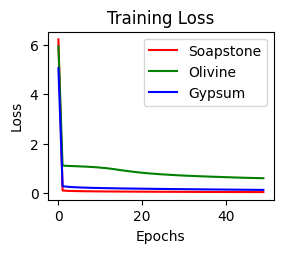

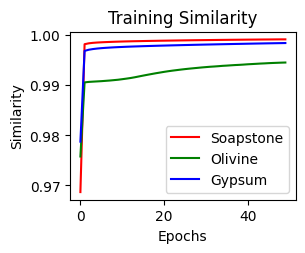

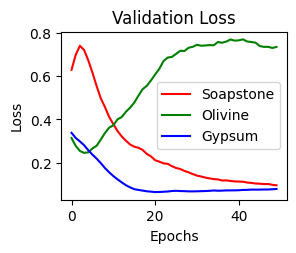

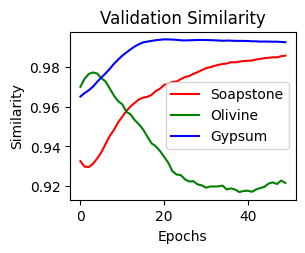

In [134]:
# Plot training loss, training similarity, validation loss, and validation similarity as subplots
plt.subplot(2, 2, 1)
plot_training_loss(tape)
plt.subplot(2, 2, 2)
plot_training_similarity(tape)
plt.subplot(2, 2, 3)
plot_validation_loss(tape)
plt.subplot(2, 2, 4)
plot_validation_similarity(tape)

In [135]:
Test_df = Test_df.apply(pd.to_numeric)
test_data = Test_df["nonLabel"].to_numpy()

In [136]:
print(mixture_val.shape)
mixture_test_data = []
soapstone_predict = []
olivine_predict = []
gypsum_predict = []

modules = [module.to(device) for module in modules]

for i in range(mixture_val.shape[0]):
    # Convert test data to tensor and move it to the same device as the models
    test_spectra = torch.from_numpy(mixture_val[i+1, :]).float().unsqueeze(0).unsqueeze(0).to(device)
    print(f"Test spectra shape: {test_spectra.shape}")
    
    # Append mixture data as numpy array to the list; ensure it's moved to CPU first
    mixture_test_data.append(test_spectra.detach().cpu().numpy())

    # For predictions, ensure the operation is on the correct device, and then move back to CPU for NumPy conversion
    soapstone_pred = modules[1](modules[0](test_spectra)).detach().cpu().numpy()
    soapstone_predict.append(soapstone_pred)
    print(f"Soapstone predict shape: {soapstone_pred.shape}")

    olivine_pred = modules[2](modules[0](test_spectra)).detach().cpu().numpy()
    olivine_predict.append(olivine_pred)
    print(f"Olivine predict shape: {olivine_pred.shape}")

    gypsum_pred = modules[3](modules[0](test_spectra)).detach().cpu().numpy()
    gypsum_predict.append(gypsum_pred)
    print(f"Gypsum predict shape: {gypsum_pred.shape}")
    break
    

(100, 1339)
Test spectra shape: torch.Size([1, 1, 1339])
Soapstone predict shape: (1, 1, 1339)
Olivine predict shape: (1, 1, 1339)
Gypsum predict shape: (1, 1, 1339)


In [137]:
mixture_test_data[-1].shape
mixture_test_data[-1].squeeze(0).shape

(1, 1339)

In [154]:
def plot_testoutput(mixture_test_data, soapstone_predict, olivine_predict, gypsum_predict, index=0):
    plt.figure(figsize=(10, 5))
    plt.plot(Spectra_df.index,mixture_test_data[index].squeeze(0).squeeze(0), label='Mixture', color='black')
    plt.plot(Spectra_df.index, soapstone_predict[index].squeeze(0).squeeze(0), label='Soapstone', color='red')
    plt.plot(Spectra_df.index,olivine_predict[index].squeeze(0).squeeze(0), label='Olivine', color='green')
    plt.plot(Spectra_df.index, gypsum_predict[index].squeeze(0).squeeze(0), label='Gypsum', color='blue')
    plt.xlabel('Raman Shift')
    # need to fix xlim range [640, 1600]
    plt.ylabel('Intensity')
    plt.legend()
    plt.title('Test Output')
    plt.show()

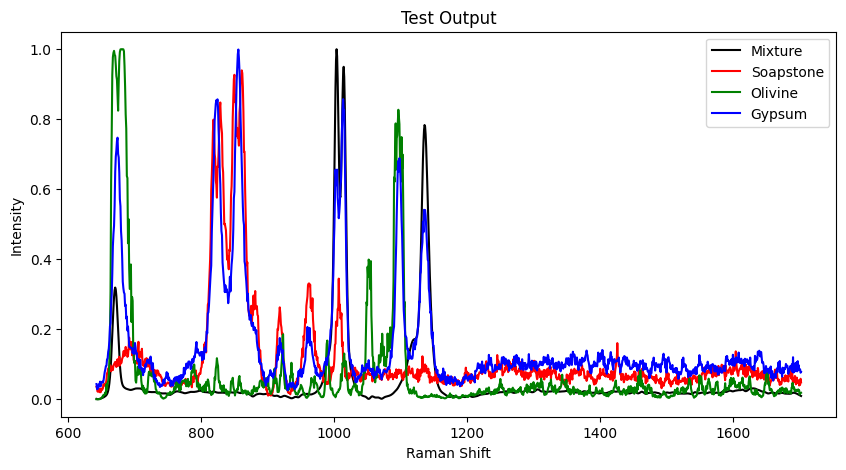

In [155]:
plot_testoutput(mixture_test_data, soapstone_predict, olivine_predict, gypsum_predict)

In [140]:
olivine_val.shape

(100, 1339)

In [162]:
def subplot_spectra(mixture_test_data, soapstone_predict, olivine_predict, gypsum_predict, index=0):
    fig, axs = plt.subplots(4, 2, figsize=(10, 20), sharey=True)
    axs[0][0].plot(Spectra_df.index, mixture_test_data[index].squeeze(0).squeeze(0), label='Mixture', color='black')
    axs[0][0].set_title('Mixture')
    axs[0][1].axis('off')
    axs[1][0].plot(Spectra_df.index, soapstone_predict[index].squeeze(0).squeeze(0), label='Soapstone', color='red')
    axs[1][0].set_title('Soapstone Prediction')
    axs[1][1].plot(Spectra_df.index, soapstone_val[index], label='Soapstone', color='red')
    axs[1][1].set_title('Soapstone Ground Truth')
    axs[2][0].plot(Spectra_df.index, olivine_predict[index].squeeze(0).squeeze(0), label='Olivine', color='green')
    axs[2][0].set_title('Olivine Prediction')
    axs[2][1].plot(Spectra_df.index, olivine_val[index], label='Olivine', color='green')
    axs[2][1].set_title('Olivine Ground Truth')
    axs[3][0].plot(Spectra_df.index, gypsum_predict[index].squeeze(0).squeeze(0), label='Gypsum', color='blue')
    axs[3][0].set_title('Gypsum Prediction')
    axs[3][1].plot(Spectra_df.index, gypsum_val[index], label='Gypsum', color='blue')
    axs[3][1].set_title('Gypsum Ground Truth')
    plt.show()

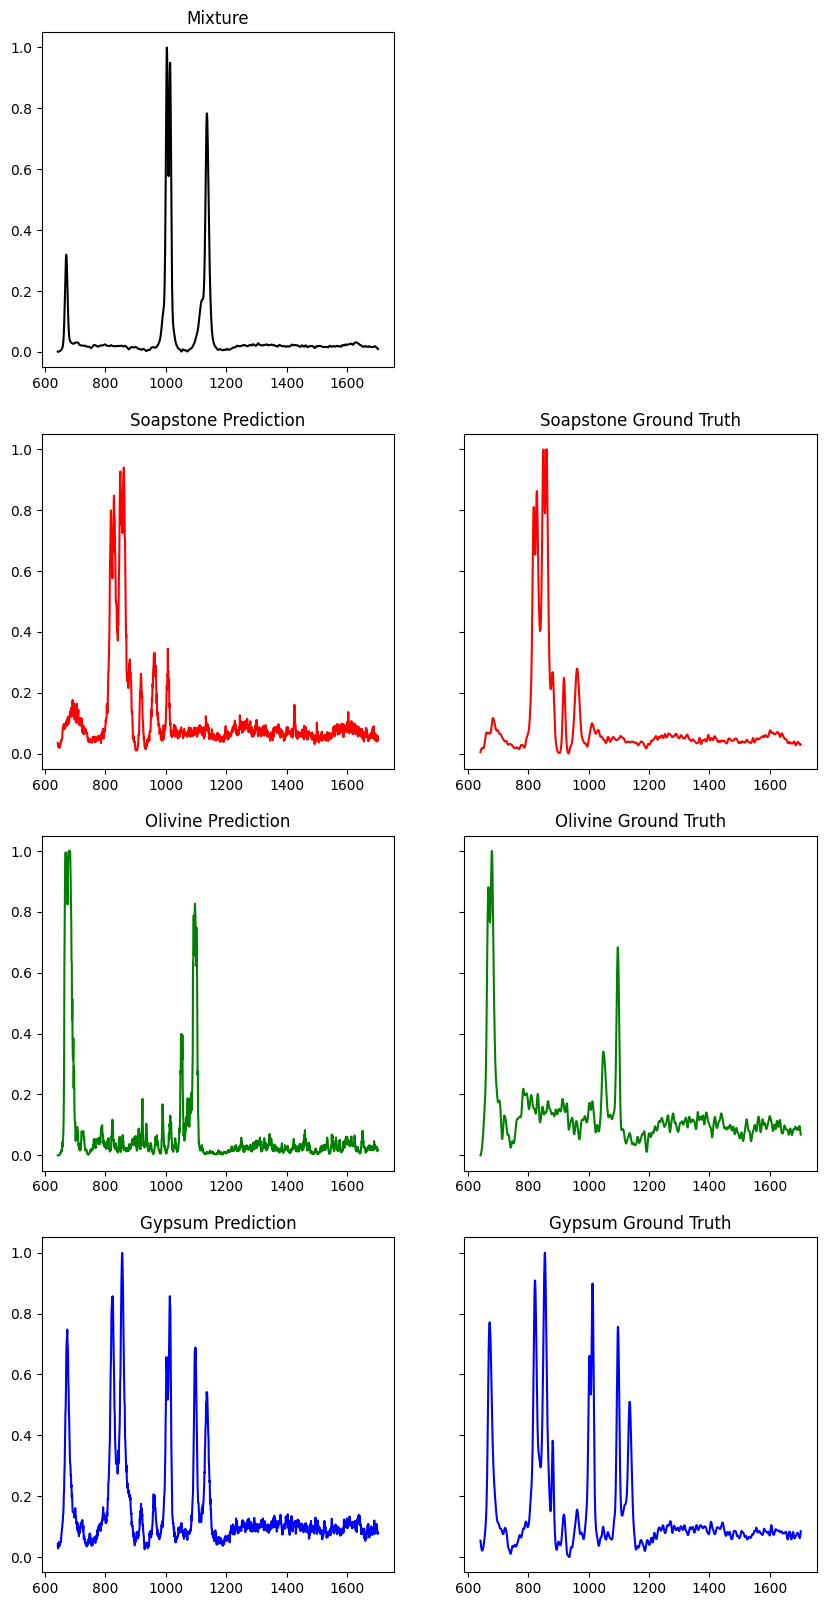

In [163]:
subplot_spectra(mixture_test_data, soapstone_predict, olivine_predict, gypsum_predict)

In [143]:
def test_SENN(model, val_data, criterions, comment):
    PRINT_TEMPLATE = '\ttest loss: {:.4f}/{:.4f}/{:.4f} (soapstone/olivine/gypsum); ' +\
                     'test similarity: {:.4f}/{:.4f}/{:.4f} (soapstone/olivine/gypsum)'
    soapstone_test_loss = 0
    olivine_test_loss = 0
    gypsum_test_loss = 0
    soapstone_test_similarity = torch.tensor(0.0, device=device)
    olivine_test_similarity = torch.tensor(0.0, device=device)
    gypsum_test_similarity = torch.tensor(0.0, device=device)
    test_set_length = 0
    with torch.no_grad():
        for i in range(val_data.shape[2]):
            mixture = torch.from_numpy(val_data[0, :, i]).float().unsqueeze(0).unsqueeze(0).to(device)
            soapstone = torch.from_numpy(val_data[1, :, i]).float().to(device)
            olivine = torch.from_numpy(val_data[2, :, i]).float().to(device)
            gypsum = torch.from_numpy(val_data[3, :, i]).float().to(device)

            pred_soapstone = model[1](model[0](mixture))
            pred_olivine = model[2](model[0](mixture))
            pred_gypsum = model[3](model[0](mixture))
            soapstone_loss = criterions[0](pred_soapstone.squeeze(1), soapstone.unsqueeze(0))
            olivine_loss = criterions[1](pred_olivine.squeeze(1), olivine.unsqueeze(0))
            gypsum_loss = criterions[2](pred_gypsum.squeeze(1), gypsum.unsqueeze(0))
            soapstone_test_loss += soapstone_loss
            olivine_test_loss += olivine_loss
            gypsum_test_loss += gypsum_loss
            soapstone_similarity = comment(pred_soapstone.squeeze(1), soapstone)
            olivine_similarity = comment(pred_olivine.squeeze(1), olivine)
            gypsum_similarity = comment(pred_gypsum.squeeze(1), gypsum)
            soapstone_test_similarity += torch.abs(torch.sum(soapstone_similarity)).item()
            olivine_test_similarity += torch.abs(torch.sum(olivine_similarity)).item()
            gypsum_test_similarity += torch.abs(torch.sum(gypsum_similarity)).item()
            test_set_length += 1
        soapstone_average_simi_test = soapstone_test_similarity / test_set_length
        olivine_average_simi_test = olivine_test_similarity / test_set_length
        gypsum_average_simi_test = gypsum_test_similarity / test_set_length
        print(PRINT_TEMPLATE.format(soapstone_test_loss, olivine_test_loss, gypsum_test_loss,
                                    soapstone_average_simi_test, olivine_average_simi_test, gypsum_average_simi_test))
        return {'soapstone_simi': soapstone_average_simi_test,
                'olivine_simi': olivine_average_simi_test,
                'gypsum_simi': gypsum_average_simi_test,
                'soapstone_loss': soapstone_test_loss,
                'olivine_loss': olivine_test_loss,
                'gypsum_loss': gypsum_test_loss}

In [144]:
trained_model = tape['model']
val_tape = test_SENN(trained_model, val_data, criterions, comment)

	test loss: 0.0948/0.7365/0.0777 (soapstone/olivine/gypsum); test similarity: 0.9856/0.9216/0.9923 (soapstone/olivine/gypsum)
